# Model for Blue LSBG Tangential Shear Measurements

## Introduction

Low surface brightness galaxies (LSBGs) are diffuse galaxies with a surface brightness fainter than the ambient night sky. Given their faintness, the use of traditional astronomical techniques for observation proves challenging. Weak gravitational lensing probes both the baryonic and dark matter content of these galaxies.

In this notebook, we build a model for the blue LSBG sample tangential shear measurements. We base the model around a single Navarro-Frank-white (NFW) profile. We utilize the [Planck15](https://arxiv.org/abs/1502.01589) cosmology for consistency with [Sifon et al. 2021](https://arxiv.org/pdf/1704.07847.pdf). We rely on [profiley](https://github.com/cristobal-sifon/profiley) to implement the NFW profiles. 

Note: the DES source file (2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits) is too large to upload into github and is available upon request

## Imports

* We use numpy for numerical calculation and analysis
* We use matplotlib for plotting and visualization
* We use twopoint to load in the source redshift distribution file
* We use scipy to build normal distributions and for statistical analysis
* We use profiley to generate the NFW profiles
* We use astropy to set up the cosmology
* We use colossus to set up the concentration for the NFW profile

In [1]:
#Loading packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import twopoint
from profiley.nfw import NFW
import scipy.stats as stats
from astropy.cosmology import Planck15
import colossus
from colossus.cosmology import cosmology
from colossus.halo import concentration
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from astropy import units as u
cosmology.setCosmology('planck15')

## Loading Data

We load in the blue LSBG tangential shear measurements (calculated using [TreeCorr](https://rmjarvis.github.io/TreeCorr/_build/html/index.html)) found in the data file of this repository. Theta_blue represents the angular scales of the measurements (in arcminutes), xi_blue indicates the shear signal, error_blue stands for the shape noise, cov_blue is the jackknife covariance matrix, and err_jk_blue represents the error derived from the jackknife covariance. We use a modified version of the clustering redshifts method to derive the redshift distribution, as described in the LSBG_redshiftdistribution.ipynb notebook. For the purposes of modeling, we cut off the measurements at 50 arcminutes to avoid straying into the two-halo regime.

In [2]:
#Loading measurements
theta_blue, xi_blue, error_blue, cross_term_blue = np.loadtxt('../data/gt_LSBG_blue', unpack=True)
theta_blue, xi_blue, err_jk_blue, cross_term_blue = np.loadtxt('../data/gt_LSBG_jackknife_blue', unpack=True)
cov_blue = np.loadtxt('../data/gt_jkcov_blue')
zldist_blue = np.loadtxt('../data/zldist_blue')
zldist_blue_cov = np.loadtxt('../data/zldist_blue_cov')

We load in the source redshift distributions (T). The sources are divided into four tomographic redshift bins. 

In [3]:
#Loading in the source redshift catalog
T = twopoint.TwoPointFile.from_fits('../data/2pt_NG_final_2ptunblind_02_24_21_wnz_redmagic_covupdate.fits') 

## Function Definitions

We define each of the functions used in this notebook, grouped here for ease of access. 

We define functions to calculate the $\chi^2$ and $\Delta \chi^2$ to determine the quality of the respective fit between either a model and a dataset or between two models. The $\chi ^2$ function (chi2) defines the difference between the shear measurements and the model: $$ (\gamma_{t_d} - \gamma_{t_m}) \times \mathrm{C}^{-1} \times (\gamma _{t_d} - \gamma_{t_m}). $$ $\gamma_{t_d}$ represents the tangential shear measurements, $\gamma_{t_m}$ indicates the model, and $\mathrm{C}^{-1}$ stands for the inverse of the covariance matrix. $\Delta \chi^2$ (deltachi2) characterizes the difference between two models: $$(\gamma_{t_{m1}} - \gamma_{t_{m2}}) \times \mathrm{C}^{-1} \times (\gamma_{t_{m1}} - \gamma_{t_{m2}}). $$ The $\chi^2$ statistic depends on the jackknife covariance, but the inverse of this matrix is biased and noisy. We correct for this bias by using the Hartlap-Kaufman factor ([Hartlap et al. 2007](https://arxiv.org/pdf/astro-ph/0608064.pdf)). The Hartlap-Kaufman factor scales the inverse of the covariance matrix by: $$f = (n-m-2)/(n-1),$$ with $n$ as the number of realizations (100, for our jackknife patches) and $m$ as the number of data vector entries (15, for the number of angular bins). 

In [4]:
def hartlap(n=None, m=None):
    """
    Calculates the hartlap factor
    
    n = number of realizations (in our case 100)
    m = number of data entries (in our case 15)
    
    Returns: hartlap factor
    """
    hartlap_factor = (n - m - 2)/ float(n-1)
    return hartlap_factor

In [5]:
def chi2(cov=None, model=None, measurements=None, n=None, m=None):
    """
    Calculates the chi^2, i.e. the quantifiable difference between a model and measurements
    
    cov = jackknife covariance matrix
    model = chosen model
    measurements = tangential shear measurements
    n = number of realizations
    m = number of data entries
    
    Returns: chi^2
    """
    invcov = np.linalg.inv(cov)
    chi2_bias = np.dot((measurements-model).T, np.dot(invcov, (measurements-model)))
    hartlap_factor = hartlap(n=n, m=m)
    chi2 = chi2_bias*hartlap_factor
    return chi2


In [6]:
def deltachi2(cov=None, model_1=None, model_2=None, n=None, m=None):
    """
    Calculates the delta chi^2, the quantifiable difference between two models
    
    cov = jackknife covariance matrix
    model1 = first model
    model2 = second model
    n = number of realizations 
    m = number of data entries
    
    Returns: delta chi^2
    """
    invcov = np.linalg.inv(cov)
    INVCOV = np.matrix(invcov)
    diff = np.matrix((model_1).T[0]-(model_2).T[0])
    deltachi2_bias = diff*INVCOV*diff.T
    hartlap_factor = hartlap(n=n, m=m)
    deltachi2 = deltachi2_bias*hartlap_factor
    
    return deltachi2

### Source Redshift Distribution

This function weights the four source redshift bins by galaxy count and combines them into a single source redshift distribution. In more detailed terms, we sum the weighted source redshift bins over the predefined source redshift range, and integrate over the combined distribution to find and divide by the normalization factor. In addition, we plot the four weighted source redshift bins and superimpose the combined source redshift distribution as a visualization exercise. We calculate the mean of the combined source redshift distribution.

In [7]:
def mean_source_redshift(nzs=None, zsbin=None, galcount=None):
    """
    Builds and plots combined source redshift distribution, returns the mean of the distribution
    
    nzs = normalized redshift counts
    zsbin = spread of redshift distribution
    galcount = galaxy counts per bin
    
    Returns: mean of the total source redshift distribution
    """
    nzs_galcount_total = np.sum(galcount)
    bins_weighted = []
    for i in range(4):
        bin_weighted = (nzs[i]*galcount[i]/nzs_galcount_total)
        bins_weighted.append(bin_weighted)
    zsdist = np.sum(bins_weighted, axis=0) 
    A_zs= np.trapz(zsdist)
    zsdist_norm = zsdist/A_zs
    z_mean_s = np.average(zsbin, weights=zsdist_norm)
    for i in range(4):
        plt.plot(zsbin, bins_weighted[i], label='Source Bin '+str(i+1))
    plt.plot(zsbin, zsdist_norm, color='black', label='Combined Source Bins') 
    plt.legend(frameon=False, fontsize=16)
    plt.xlim(0.0, 2.8)
    plt.xlabel('$z$', fontsize=16)
    plt.ylabel('$n(z)$', fontsize=16)
    plt.title('Source Redshift Distribution', fontsize=16)
    plt.tick_params(labelsize=14)
    plt.show()
    return z_mean_s

### NFW Profile

We define a function that walks through the first few steps of generating an NFW profile and the $\Sigma_\mathrm{crit}$ factor. 


The NFW profile describes the density of dark matter as a function of the distance from the center of a galaxy or cluster. The density profile at a radius r is given by: $$\rho_\mathrm{NFW} (r) = \frac{\rho_s}{r/r_s(1+r/r_s)^2}. $$ $r _s$ represents the scale radius, defined as $$r_s = \frac{r_{200}}{c_s}.$$ $c_s$ represents the concentration of the halo and $r_{200}$ signifies the virial radius, or the radius at which the mean density of the halo reaches 200 times the critical density of the universe. $\rho_s$ indicates the characteristic density of the halo, or the density of the dark matter halo within the scale radius. The characteristic density can be derived from the halo mass, scale radius, and concentration through: $$\rho_s = \frac{M_\mathrm{200c}}{4\pi r_s^3(\ln(1+c_s) - c_s/(1+c_s))}. $$ $M_\mathrm{200c}$ stands for the effective halo mass of the sample. 

The $\Sigma_\mathrm{crit}$ factor is a geometrical factor that varies with the specifics of the lensing system. The factor is defined as $$\Sigma_\mathrm{crit} (z_L, z_S) = \frac{c^2}{4\pi G} \frac{D_S}{D_{LS}D_L}.$$ $z_l$ and $z_s$ indicate the lens and source redshift, $c$ represents the speed of light, and $D_S$, $D_L$, and $D_{LS}$ characterize the respective angular diameter distances to the source, the lens, and between the source and lens. 

We calculate the angular diameter distance at a specified lens redshift given the 'Planck15' cosmology (da). To obtain the physical radii of the halos, we multiply this redshift by the angular separations (r_mpc). We calculate the NFW profile based on the mass, concentration, and lens redshift. Using this NFW profile and the source redshift, we calculate the $\Sigma_\mathrm{crit}$ factor. 

In [8]:
def nfw_generation(mass=None, zl=None, zs=None, scales=None):
    """
    Calculates a simple NFW profile and sigma_crit factor at a single lens and source redshift
    
    mass = mass of the halo (solar masses)
    zl = lens redshift
    zs = source redshift
    scales = angular scales (angular separations in arcmin)
    
    Returns: angular diameter distance at lens redshift, physical radius at that redshift, NFW profile, and sigma_crit factor
    """
    da = Planck15.angular_diameter_distance(zl) 
    r_mpc = da*scales 
    concentration_xi = concentration.concentration(mass, '200c', zl, 'ishiyama21')
    nfw = NFW(mass, concentration_xi, zl, overdensity=200, background='c') 
    sigma_crit = nfw.sigma_crit([zs])
    return da, r_mpc, nfw, sigma_crit

### Tangential Shear Model

We define a function that returns the modeled tangential shear profile for the dark matter halo integrated over the lens redshift distribution. 

We use the NFW profile to calculate the excess surface density ($\Delta \Sigma(R)$), the fraction of mass above the average surface mass density in a region at the projected radius $R$. The excess surface density determines the deflection of light for gravitational lensing events. It can be broken into two components: the projected surface density $\Sigma(R)$ at the radius $R$, and the cumulative surface density $\Sigma(<R)$ within the radius $R$. We define the cumulative surface density as: $$\Sigma(<R) = \frac{2}{R^2}\int_0^R \chi\Sigma(\chi) d\chi, $$ where $\chi$ represents the distance along the line of sight. We define the projected surface density as: $$\Sigma(R) = 2\int_0^{+\infty} \rho_\mathrm{NFW} (\sqrt{\chi^2+R^2}) d\chi.$$ The NFW profile thus becomes a mediator between the halo mass and the excess surface density. 

With the excess surface density and the $\Sigma_\mathrm{crit}$ factor, we can model the tangential shear profile for  individual lens and source redshifts as $$\gamma_{t}(z_S, z_L, \theta) = \frac{\Delta\Sigma(R(\theta, z_L))}{\Sigma_\mathrm{crit}(z_L, z_S)}.$$ We evaluate the calculated shear profile at each lens redshift, multiply by the indexed value of the normalized lens redshift distribution, and integrate over the lens redshift distribution to obtain the shear profile. Our model becomes: $$\gamma_{t,\mathrm{pop}}(\theta) = \int \gamma_{t}(z_S, z_L, \theta) \times n(z_{L}) dz_L.$$

In [9]:
def halo_generation(zlrange=None, zldist_norm=None, mass=None, zs=None, scales=None):
    """
    Calculates the tangential shear profile for the halo integrated over the lens redshift distribution
    
    zlrange = range of lens redshifts
    zldist_norm = normalized lens redshift distribution
    mass = mass of halo (solar masses)
    concentration = density of halo
    zs = source redshift
    scales = angular separations (arcminutes)
    
    Returns: tangential shear model for halo integrated over lens redshift distribution
    """
    gt_list = []
    for i, xi in enumerate(zlrange):
        da, r_mpc, nfw, sigma_crit = nfw_generation(mass=mass, zl=xi, zs=zs, scales=scales)
        esd = nfw.projected_excess(r_mpc) 
        gt = esd/sigma_crit 
        gt_norm = gt*zldist_norm[i] 
        gt_list.append(gt_norm) 
    gt_total = np.trapz(np.array(gt_list), axis=0)
    return(gt_total)

## Defining Parameters

We define the parameters for the construction of the source redshift distribution and the tangential shear model. 

### Redshift Distributions

We define the necessary parameters to extract the mean redshift of the source redshift distribution, drawn from the shapes catalog. We overlay the combined source redshift distribution on the four weighted tomographic redshift bins. 

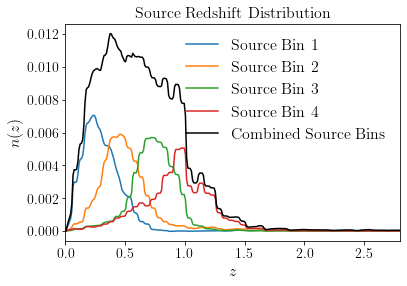

0.6312412596033679


In [10]:
nzs = (T.kernels[0].nzs) #Galaxy counts
zsbin = (T.kernels[0].z) #Source redshift spread
galcount = np.array([24940465,25280405,24891859,25091297]) #Number of galaxies per bin
zs = mean_source_redshift(nzs, zsbin, galcount) #Mean source redshift
print(zs)

We define the lens redshift range and plot the lens redshift distribution.

In [11]:
zlrange = np.linspace(0.01, 0.19, 10)

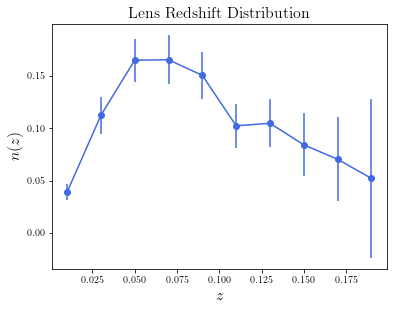

In [12]:
plt.figure(figsize=(6,4.5))
plt.errorbar(zlrange, zldist_blue, np.sqrt(np.diag(zldist_blue_cov)), marker='o', color='royalblue')
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$n(z)$', fontsize=16)
plt.title('Lens Redshift Distribution', fontsize=16)
plt.show()

### Tangential Shear Model Parameters

We outline the parameters for the tangential shear model. We define a best-fit halo mass and an upper-bound halo mass. We convert the angular separations (derived from the shear measurements, in arcminutes) to radians (theta_rad). We define the number of realizations (n) and the number of data entries (m) to calculate the hartlap factor. 

In [13]:
theta_rad = theta_blue/60*np.pi/180 
mass_bestfit = 10**11.0
mass_upperbound = 10**11.84 
n = 100
m = 15 

## Tangential Shear Model

We call for two iterations of the tangential shear model, one with a best fit halo mass, and one with an upper bound halo mass. 

In [14]:
#Call for model
total_model_bestfit = halo_generation(zlrange=zlrange, zldist_norm=zldist_blue, mass=mass_bestfit, zs=zs, scales=theta_rad)
total_model_upperbound = halo_generation(zlrange=zlrange, zldist_norm=zldist_blue, mass=mass_upperbound, zs=zs, scales=theta_rad)


### Tangential Shear Model Plot

We compare the tangential shear model to the blue LSBG shear measurements. We calculate the physical radii corresponding to the mean lens redshift to define an additional x-axis. The errorbars on the measurements come from the jackknife covariance. In addition, we plot the absolute value of the shear measurements. The triangle marker indicates that the selected datapoint has a negative value.

In [15]:
da_rmpc = Planck15.angular_diameter_distance(0.09)
r_mpc_scales = (da_rmpc)*theta_rad

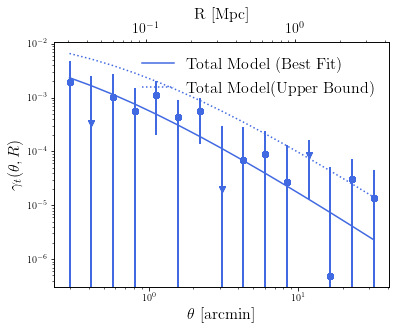

In [16]:
#Plotting measurements over angular scales 
fig, ax1 = plt.subplots(figsize=(6,4.5), ncols=1)
for i in range(len(theta_blue)):
        if xi_blue[i]>0:
            ax1.errorbar(theta_blue[:15], xi_blue[:15], err_jk_blue[:15], fmt="o", color='royalblue')
        if xi_blue[i]<=0:
            ax1.errorbar(theta_blue[:15], -1*xi_blue[:15], err_jk_blue[:15], fmt="v", color='royalblue')
ax2 = ax1.twiny()

#Plotting model over physical scales
ax2.plot(r_mpc_scales[:15], total_model_bestfit[:15], color='royalblue', label = 'Total Model (Best Fit)')
ax2.plot(r_mpc_scales[:15], total_model_upperbound[:15], ls = ':', color='royalblue', label = 'Total Model(Upper Bound)')

ax1.set_ylabel(r'$\gamma_t(\theta, R)$', fontsize=16)
ax1.set_xlabel('$\\theta$ [arcmin]', fontsize=16)
ax2.set_xlabel('R [Mpc]', fontsize=16)

ax2.legend(frameon=False, fontsize=16, loc='upper right')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.tick_params(axis='both', labelsize=14)
plt.show()


We include the $\chi^2$ calculations between the model and the blue LSBG tangential shear measurements to evaluate the strength of the fit.

In [17]:
#Chi2 calculation between model and measurements
chi2_upper = chi2(cov=cov_blue[:15,:15], model=total_model_upperbound[:15], measurements=np.reshape(xi_blue[:15], (15,1)), n=n, m=m)
print(chi2_upper)

chi2_total = chi2(cov=cov_blue[:15,:15], model=total_model_bestfit[:15], measurements=np.reshape(xi_blue[:15], (15,1)), n=n, m=m)
print(chi2_total)

[[24.97281673]]
[[4.10191114]]
